<a href="https://colab.research.google.com/github/vmacf/redes_neurais/blob/master/CNN/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning

---

### Nessa aula, vamos treinar a rede Neural VGG com a base de dados CIFAR-10



### 1. Carrega a Base de dados CIFAR-10

In [0]:
import keras
from keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train_orig, y_train), (x_test_orig, y_test) = cifar10.load_data()

x_train_orig = x_train_orig.astype('float32')
x_test_orig = x_test_orig.astype('float32')

170500096/170498071 [==============================] - 40s 0us/step


### 2. Redimensiona a imagem para o memo tamanho da imagem de treinamento do modelo base. 

Nesse caso, as imagens da imagenet possuem formato (224,224,3), porém, por conta de memória, iremos trabalhar com um formato menor.

In [0]:
import skimage.transform
import numpy as np
import scipy 
from scipy import misc
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg16 import preprocess_input
import gc

img_width, img_height = 64, 64
depth = 3

x_train = np.empty((x_train_orig.shape[0],img_width,img_height,depth)).astype('float32')
for i in range(x_train_orig.shape[0]):
    #x_train[i] = imresize(x_train_orig[i], (img_width,img_height,3), interp='bilinear', mode=None)
    x_train[i] = skimage.transform.resize(x_train_orig[i], (img_width, img_height), mode='constant') 
    #np.delete(x_train_orig,i)    

x_test = np.empty((x_test_orig.shape[0],img_width,img_height,depth))
for i in range(x_test_orig.shape[0]):
    #x_test[i] = imresize(x_test_orig[i], (img_width,img_height,3), interp='bilinear', mode=None)
    x_test[i] = skimage.transform.resize(x_test_orig[i], (img_width, img_height), mode='constant') 
    #np.delete(x_test_orig,i)

#free memory  
del x_train_orig
del x_test_orig  

gc.collect()

#x_train = preprocess_input(x_train)
#x_test = preprocess_input(x_test)  


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0

###2. Reescale as imagens dividindo todos os pixels por 255

In [0]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 3. Comece importando os pacotes necessários para o projeto

In [0]:
# import the necessary packages
#from pyimagesearch.nn.conv import LeNet
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras import backend as K
import matplotlib.pyplot as plt


from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, Input
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

### 4.  Dividir base de dados em conjuntos de treinamento, teste e validação.

In [0]:
from keras.utils import np_utils

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 64, 64, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Carregue uma das redes neurais disponíveis

####Nesse site há algumas redes neurais disponíveis:

https://github.com/fchollet/deep-learning-models

In [0]:
image_input = Input(shape=(img_width, img_height, depth))

# create the base pre-trained model
base_model = VGG16(input_tensor=image_input,weights = "imagenet", include_top=False)
#base_model = InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step


## 6. Congela as camadas que não serão treinadas. 

Logo abaixo, há uma opção pra congelar apenas as 5 primeiras camadas.

In [0]:
# Freeze the layers which you don't want to train. 
for layer in base_model.layers:
#Here I am freezing the first 5 layers.
#for layer in model.layers[:5]:
  layer.trainable = False


## 7. Construa a saída da rede neural

Há uma opção para uma camada Flatten simples e outra opção para adicionar uma Camada GlobalAveragePooling (tipo de camada recente, que diminui bastante o número de parâmetros da rede neural)

In [0]:
#Add custom layer
x = base_model.output
x = Flatten()(x)

#or add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)  


Camadas intermediárias e de saída

In [0]:
#Add intermediary layer
x = Dense(256, activation="relu")(x)
#Add final layer
predictions = Dense(10, activation="softmax")(x)

# creating the final model
model = Model(inputs=base_model.input, outputs=predictions)

#model_final = Model(input = model.input, output = predictions)
#model = model_final

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

## 7. Compile o modelo

In [0]:
print("[INFO] compiling model...")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


[INFO] compiling model...


### 8. Treine o Modelo

In [0]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

nepochs = 10
hist = model.fit(x_train, y_train, batch_size=128, epochs=nepochs,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 45000 samples, validate on 5000 samples
Epoch 1/10
 - 27s - loss: 1.1595 - acc: 0.5971 - val_loss: 0.9784 - val_acc: 0.6660

Epoch 00001: val_loss improved from inf to 0.97840, saving model to model.weights.best.hdf5
Epoch 2/10
 - 21s - loss: 0.9203 - acc: 0.6806 - val_loss: 0.9408 - val_acc: 0.6768

Epoch 00002: val_loss improved from 0.97840 to 0.94078, saving model to model.weights.best.hdf5
Epoch 3/10
 - 22s - loss: 0.8405 - acc: 0.7071 - val_loss: 0.8967 - val_acc: 0.6898

Epoch 00003: val_loss improved from 0.94078 to 0.89674, saving model to model.weights.best.hdf5
Epoch 4/10
 - 22s - loss: 0.7846 - acc: 0.7237 - val_loss: 0.8877 - val_acc: 0.6970

Epoch 00004: val_loss improved from 0.89674 to 0.88768, saving model to model.weights.best.hdf5
Epoch 5/10
 - 22s - loss: 0.7378 - acc: 0.7418 - val_loss: 0.8654 - val_acc: 0.7006

Epoch 00005: val_loss improved from 0.88768 to 0.86542, saving model to model.weights.best.hdf5
Ep

### 9. Carrege o modelo com a melhor acurácia no conjunto de validação

In [0]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### **10**. Calcule a acurácia no conjunto de teste

In [0]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7013


### **11**. Informações sobre acurácia no treinamento

[INFO] evaluating network...
              precision    recall  f1-score   support

    airplane       0.76      0.78      0.77      1000
  automobile       0.82      0.79      0.81      1000
        bird       0.61      0.65      0.63      1000
         cat       0.58      0.44      0.50      1000
        deer       0.56      0.75      0.64      1000
         dog       0.74      0.48      0.58      1000
        frog       0.68      0.78      0.73      1000
       horse       0.70      0.78      0.74      1000
        ship       0.86      0.80      0.83      1000
       truck       0.75      0.77      0.76      1000

   micro avg       0.70      0.70      0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



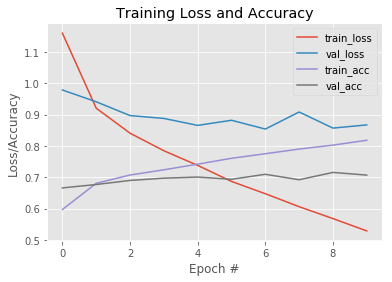

In [0]:
# evaluate the network
print("[INFO] evaluating network...")

# get predictions on the test set
predictions = model.predict(x_test, batch_size=128)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


print(classification_report(y_test.argmax(axis=1),
predictions.argmax(axis=1),
target_names=cifar10_labels))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, nepochs), hist.history["loss"], label="train_loss" )
plt.plot(np.arange(0, nepochs), hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, nepochs), hist.history["acc" ], label="train_acc" )
plt.plot(np.arange(0, nepochs), hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### 10. Veja algumas predições

Pode dar indicações de objetos mal classificados

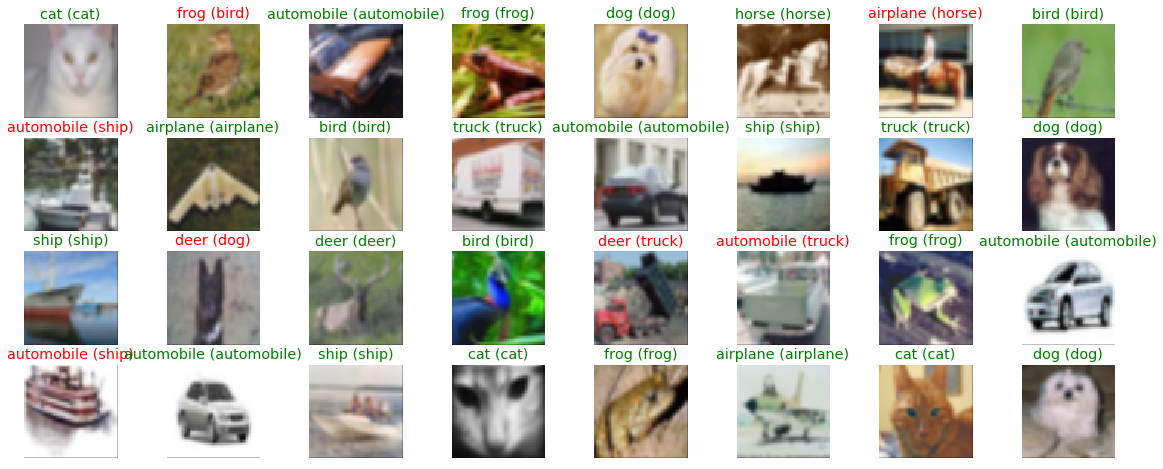

In [0]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

##Exercício

1. Compare o resultado obtigo pela VGG16 com o resultado da Inception e da MobileNet
